In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from kan import KAN, create_dataset, SYMBOLIC_LIB, add_symbolic
import torch
dataset = {}


In [2]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device 

device(type='cpu')

In [25]:
df = pd.read_csv('correct_bogi.csv')
df.drop(['year'], axis=1, inplace=True)
df

,DateTime,Vehicles,day,week,month,time
0,2023-01-01 00:00:00,140.0,1,7,1,0
1,2023-01-01 01:00:00,140.0,1,7,1,1
2,2023-01-01 02:00:00,100.0,1,7,1,2
3,2023-01-01 03:00:00,60.0,1,7,1,3
4,2023-01-01 04:00:00,160.0,1,7,1,4
...,...,...,...,...,...,...
4337,2023-06-30 17:00:00,2017.0,30,5,6,17
4338,2023-06-30 18:00:00,1984.0,30,5,6,18
4339,2023-06-30 19:00:00,1792.0,30,5,6,19
4340,2023-06-30 20:00:00,956.0,30,5,6,20


In [26]:
df5 = df[df['month'] != 6]
df6 = df[df['month'] == 6]

In [27]:
X_data = df5.drop(['DateTime', 'Vehicles'], axis=1)
Y_data = df5['Vehicles']
X_uniqe = df6.drop(['DateTime', 'Vehicles'], axis=1)
Y_uniqe = df6['Vehicles']

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

In [29]:
min_max_fit = MinMaxScaler()
X_uniqe = min_max_fit.fit_transform(X_uniqe)
X_train = min_max_fit.fit_transform(X_train)
X_test = min_max_fit.fit_transform(X_test)

In [30]:
dataset['train_input'] = torch.tensor(X_train)
dataset['train_label'] = torch.tensor(Y_train.to_numpy().reshape(-1,1))
dataset['test_input'] = torch.tensor(X_test)
dataset['test_label'] = torch.tensor(Y_test.to_numpy().reshape(-1,1))

In [31]:
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([2718, 4]), torch.Size([2718, 1]))

In [32]:
dataset['test_input'].shape, dataset['test_label'].shape

(torch.Size([906, 4]), torch.Size([906, 1]))

In [76]:

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,9,3,1], grid=10, k=5, seed=0)


In [80]:
# train the model
model.train(dataset, opt="LBFGS", steps=40);
model = model.prune()
model(dataset['train_input'])
# model.suggest_symbolic(1,0,0)

train loss: 1.15e+02 | test loss: 1.42e+02 | reg: 9.71e+01 : 100%|██| 40/40 [04:15<00:00,  6.40s/it]


tensor([[ 121.0691],
        [ 169.3903],
        [ 245.1095],
        ...,
        [ 590.8913],
        [1346.3374],
        [1256.1878]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [81]:
# model.auto_symbolic(lib=['gaussian','sin'])

In [82]:
predict = model.forward(dataset['test_input'])

In [83]:
r2_score(dataset['test_label'].detach().numpy(), predict.detach().numpy())

0.9009734823882829

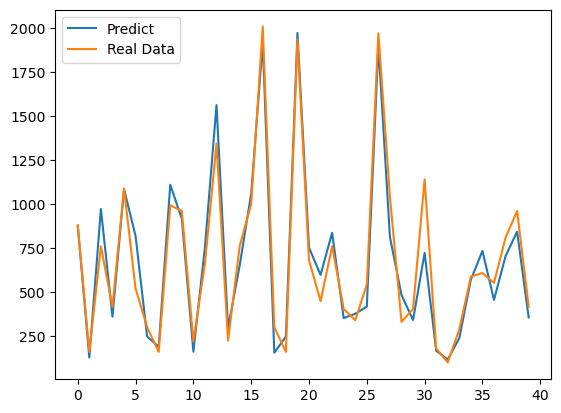

In [75]:
# Предположим, predict и dataset['test_label'] - это тензоры PyTorch
plt.plot(predict.detach().numpy()[:40], label='Predict')
plt.plot(dataset['test_label'].detach().numpy()[:40], label='Real Data')

# Добавляем легенду
plt.legend(loc="upper left")

# Показываем график
plt.show()

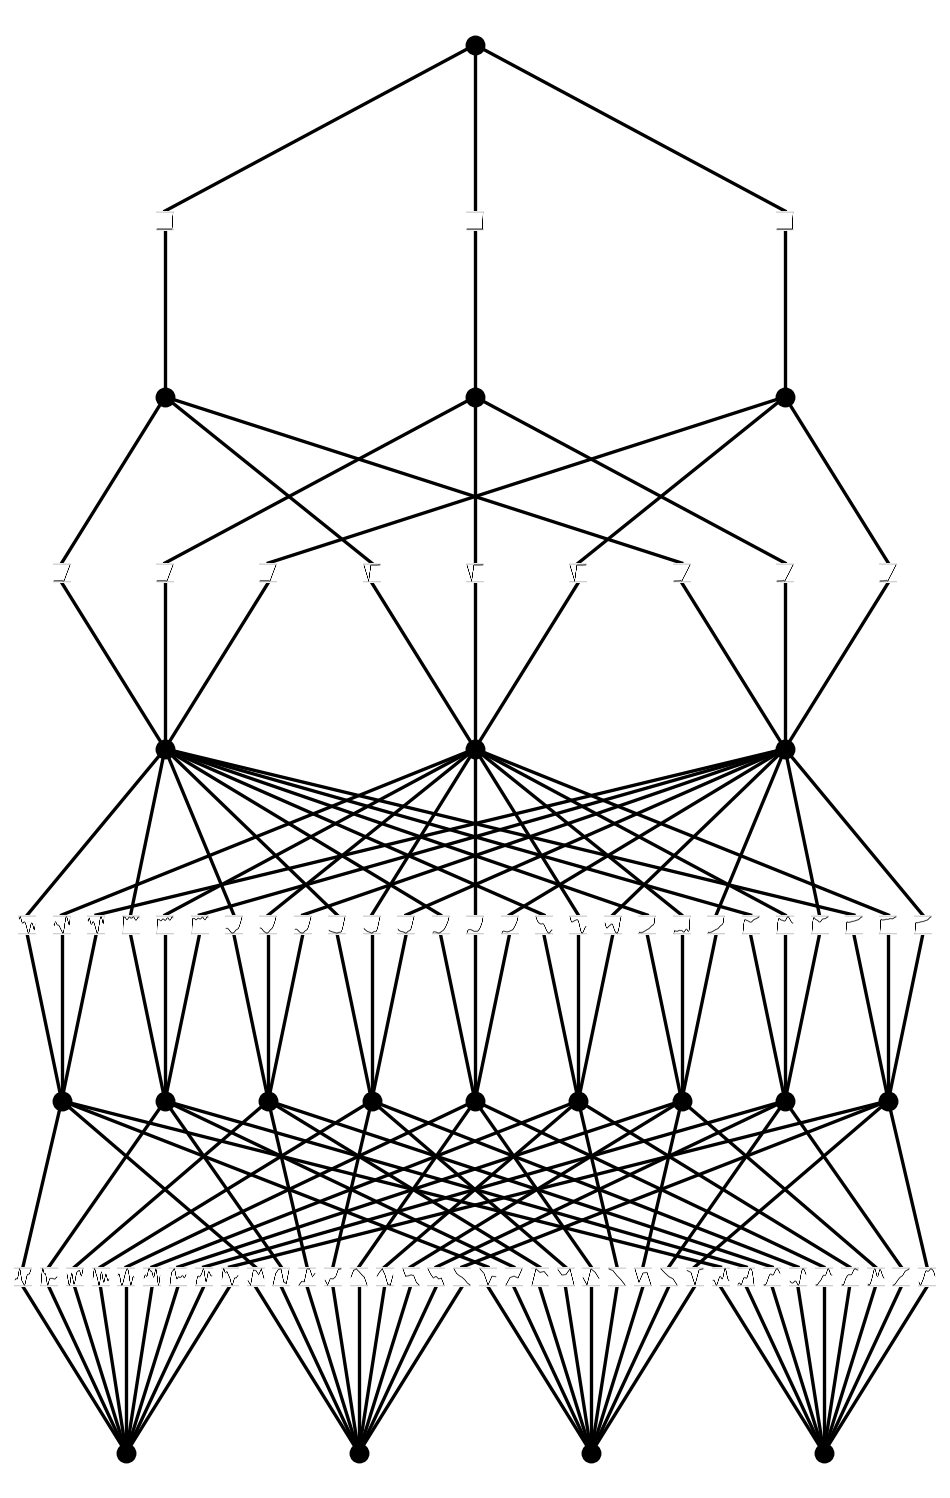

In [62]:
model.plot(beta=100,scale=1.2)

In [41]:
result = {}
for i in range(1, 15):
    model.train(dataset, opt="LBFGS", steps=10*i);
    predict = model.forward(dataset['test_input'])
    r2 = r2_score(dataset['test_label'].detach().numpy(), predict.detach().numpy())
    result[i] = r2
    print(result)
    if r2 > 0.98:
        break
    
    
    

train loss: 1.67e+02 | test loss: 1.72e+02 | reg: 3.19e+02 : 100%|██| 10/10 [01:00<00:00,  6.07s/it]


{1: 0.8550550844819819}


train loss: 1.59e+02 | test loss: 1.67e+02 | reg: 3.10e+02 : 100%|██| 20/20 [01:42<00:00,  5.11s/it]


{1: 0.8550550844819819, 2: 0.863086193911758}


train loss: 1.57e+02 | test loss: 1.65e+02 | reg: 3.07e+02 : 100%|██| 30/30 [03:02<00:00,  6.08s/it]


{1: 0.8550550844819819, 2: 0.863086193911758, 3: 0.8657048474672508}


train loss: 1.52e+02 | test loss: 1.65e+02 | reg: 3.10e+02 : 100%|██| 40/40 [03:52<00:00,  5.81s/it]


{1: 0.8550550844819819, 2: 0.863086193911758, 3: 0.8657048474672508, 4: 0.865968817989222}


train loss: 1.59e+02 | test loss: 1.71e+02 | reg: 3.27e+02 : 100%|██| 50/50 [04:48<00:00,  5.77s/it]


{1: 0.8550550844819819, 2: 0.863086193911758, 3: 0.8657048474672508, 4: 0.865968817989222, 5: 0.8569708188623546}


train loss: 1.57e+02 | test loss: 1.70e+02 | reg: 3.23e+02 :  45%|▉ | 27/60 [02:17<02:47,  5.08s/it]

KeyboardInterrupt

